### **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from imblearn.under_sampling import TomekLinks, RandomUnderSampler

from lightgbm import LGBMClassifier

### **Settings**

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### **Load Dataset**

In [3]:
df = pd.read_csv(r'D:\Project\Python\Portfolio\Big Data\[Bottleneck] CLS - Spring Leaf Markeing Response\data\train.csv')

display(df.head())

C:\Users\msi.pc\AppData\Local\Temp\ipykernel_23068\3187415195.py:1: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'D:\Project\Python\Portfolio\Big Data\[Bottleneck] CLS - Spring Leaf Markeing Response\data\train.csv')


,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,...,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,False,False,False,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,BRANCH,1


In [4]:
print(f'Dataset shape: {df.shape}')

Dataset shape: (145231, 1934)


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float64(477), int64(1406), object(51)
memory usage: 2.3 GB


In [6]:
def is_convertable(col: pd.Series) -> bool:
  if col.dtype == np.int64 and\
      col.max() <= np.iinfo(np.int32).max and\
      col.min() >= np.iinfo(np.int32).min: return True
  
  if col.dtype == np.float64 and\
      col.max() <= np.finfo(np.float32).max and\
      col.min() >= np.finfo(np.float32).min: return True
  
  if np.isnan(col.max()): return True
      
  return False

def save_memory(df_original: pd.DataFrame) -> pd.DataFrame:
  int_cols = df_original.select_dtypes(np.int64).columns
  float_cols = df_original.select_dtypes(np.float64).columns
  
  int_cols = [col for col in int_cols if is_convertable(df_original[col])]
  float_cols = [col for col in float_cols if is_convertable(df_original[col])]
  
  int_cols = {col: 'int32' for col in int_cols}
  float_cols = {col: 'float32' for col in float_cols}

  df_original = df_original.astype(int_cols)
  df_original = df_original.astype(float_cols)
  
  return df_original
  
df = save_memory(df)

In [7]:
def convert_str2cat(df_original: pd.DataFrame) -> pd.DataFrame:
  cat_cols = df_original.select_dtypes('object').columns
  
  cat_cols = {col: 'category' for col in cat_cols}
  df_original = df_original.astype(cat_cols)
  
  return df_original

df = convert_str2cat(df)

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: category(51), float32(477), int32(1406)
memory usage: 1.0 GB


### **EDA**

##### **A. Target value**

Ratio of target (1 and 0): 3.300210227104492


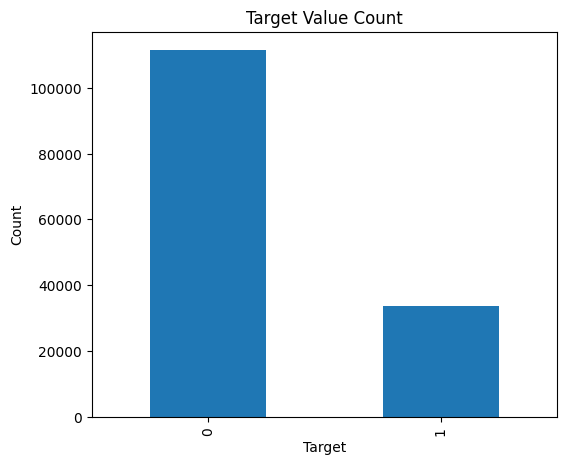

In [9]:
target_dist = df['target'].value_counts().sort_values(ascending=False)
target_dist.plot(kind='bar',
                 figsize=(6, 5),
                 title='Target Value Count',
                 xlabel='Target',
                 ylabel='Count')

mayor_minor_ratio = target_dist[0] / target_dist[1]
print(f'Ratio of target (1 and 0): {mayor_minor_ratio}')

##### **B. Missing value - column**

<Axes: title={'center': 'Top 50 of % of Missing Value vs Feature'}, xlabel='Feature', ylabel='% of Missing Value'>

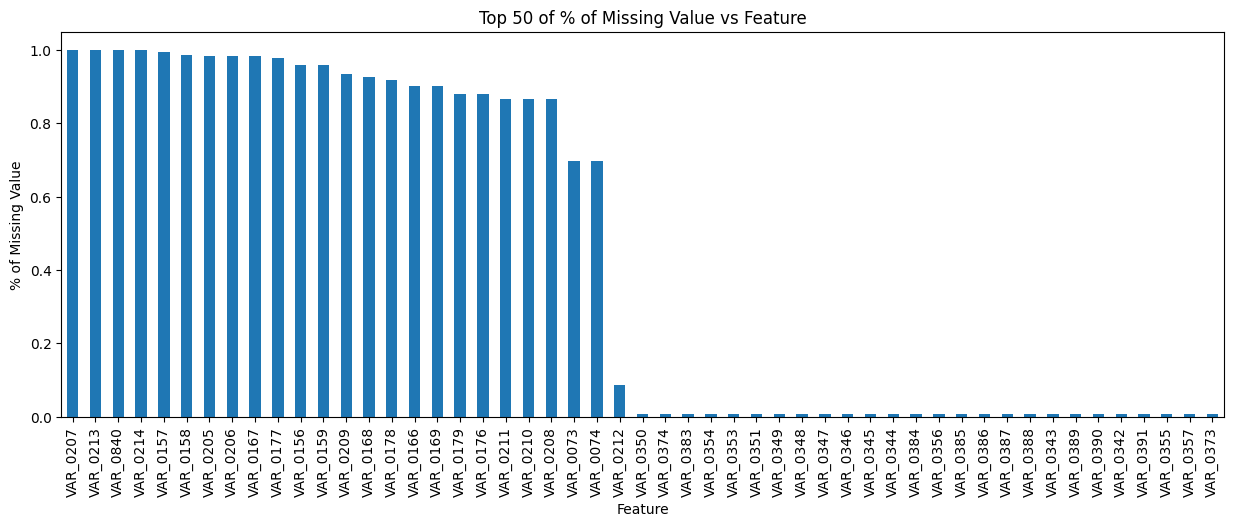

In [10]:
df_cols_null = df.isna().mean().sort_values(ascending=False).drop('target')

df_cols_null[:51].plot(kind='bar',
                       figsize=(15, 5),
                       title=r'Top 50 of % of Missing Value vs Feature',
                       xlabel='Feature',
                       ylabel=r'% of Missing Value')

In [11]:
df_cols_null_70p = df_cols_null[df_cols_null > 0.69]
df_cols_null_70p = df_cols_null_70p.index.to_list()

print(f'Numbers of feature(s): {len(df_cols_null_70p)}\nFeatures: {df_cols_null_70p}')

Numbers of feature(s): 24
Features: ['VAR_0207', 'VAR_0213', 'VAR_0840', 'VAR_0214', 'VAR_0157', 'VAR_0158', 'VAR_0205', 'VAR_0206', 'VAR_0167', 'VAR_0177', 'VAR_0156', 'VAR_0159', 'VAR_0209', 'VAR_0168', 'VAR_0178', 'VAR_0166', 'VAR_0169', 'VAR_0179', 'VAR_0176', 'VAR_0211', 'VAR_0210', 'VAR_0208', 'VAR_0073', 'VAR_0074']


##### **C. Single unique value feature**

In [12]:
df_num_cols = df.select_dtypes(exclude='category').columns
df_cat_cols = df.select_dtypes('category').columns

print(f'Numbers of numerical feature(s): {len(df_num_cols)}')
print(f'Numbers of categorical feature(s): {len(df_cat_cols)}')

Numbers of numerical feature(s): 1883
Numbers of categorical feature(s): 51


<Axes: title={'center': 'Bottom 50 of Numbers of Unique Value(s) vs Feature'}, xlabel='Feature', ylabel='Numbers of Unique Value(s)'>

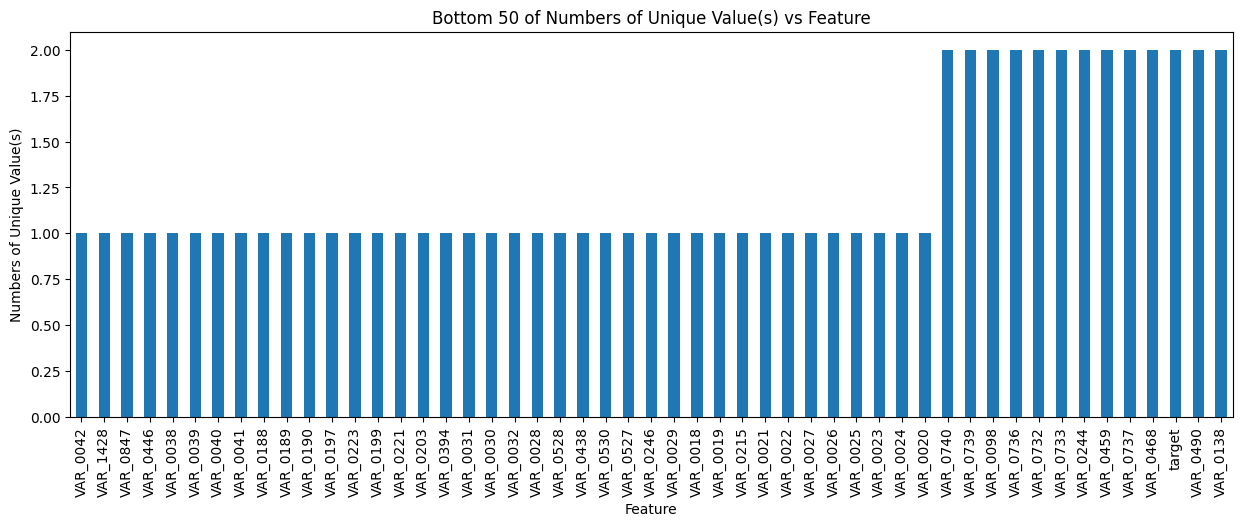

In [13]:
df_num_cols_low_var = df[df_num_cols].nunique().sort_values()
df_num_cols_low_var = df_num_cols_low_var[df_num_cols_low_var > 0][:51]
df_num_cols_low_var.plot(kind='bar',
                       figsize=(15, 5),
                       title=r'Bottom 50 of Numbers of Unique Value(s) vs Feature',
                       xlabel='Feature',
                       ylabel='Numbers of Unique Value(s)')

In [14]:
df_num_cols_single = df_num_cols_low_var[df_num_cols_low_var == 1]
df_num_cols_single = df_num_cols_single.index.to_list()

print(f'Numbers of feature(s): {len(df_num_cols_single)}\nFeatures: {df_num_cols_single}')

Numbers of feature(s): 38
Features: ['VAR_0042', 'VAR_1428', 'VAR_0847', 'VAR_0446', 'VAR_0038', 'VAR_0039', 'VAR_0040', 'VAR_0041', 'VAR_0188', 'VAR_0189', 'VAR_0190', 'VAR_0197', 'VAR_0223', 'VAR_0199', 'VAR_0221', 'VAR_0203', 'VAR_0394', 'VAR_0031', 'VAR_0030', 'VAR_0032', 'VAR_0028', 'VAR_0528', 'VAR_0438', 'VAR_0530', 'VAR_0527', 'VAR_0246', 'VAR_0029', 'VAR_0018', 'VAR_0019', 'VAR_0215', 'VAR_0021', 'VAR_0022', 'VAR_0027', 'VAR_0026', 'VAR_0025', 'VAR_0023', 'VAR_0024', 'VAR_0020']


<Axes: title={'center': 'Bottom of Numbers of Unique Value(s) vs Feature'}, xlabel='Feature', ylabel='Numbers of Unique Value(s)'>

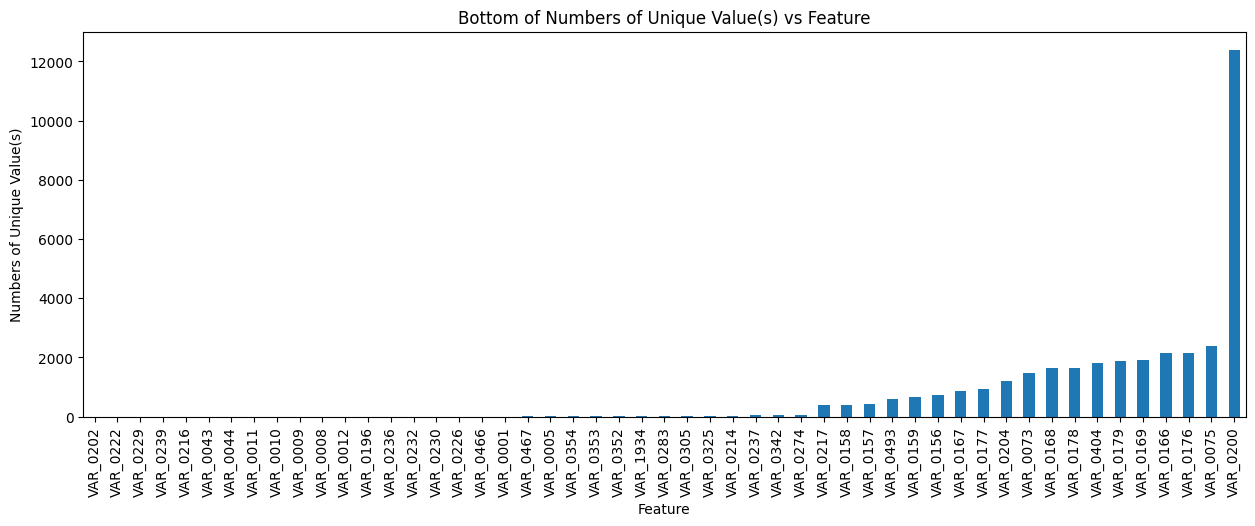

In [15]:
df_cat_cols_low_var = df[df_cat_cols].nunique().sort_values()
df_cat_cols_low_var = df_cat_cols_low_var[df_cat_cols_low_var > 0][:51]
df_cat_cols_low_var.plot(kind='bar',
                       figsize=(15, 5),
                       title=r'Bottom of Numbers of Unique Value(s) vs Feature',
                       xlabel='Feature',
                       ylabel='Numbers of Unique Value(s)')

In [16]:
df_cat_cols_single = df_cat_cols_low_var[df_cat_cols_low_var == 1]
df_cat_cols_single = df_cat_cols_single.index.to_list()

print(f'Numbers of feature(s): {len(df_cat_cols_single)}\nFeatures: {df_cat_cols_single}')

Numbers of feature(s): 13
Features: ['VAR_0202', 'VAR_0222', 'VAR_0229', 'VAR_0239', 'VAR_0216', 'VAR_0043', 'VAR_0044', 'VAR_0011', 'VAR_0010', 'VAR_0009', 'VAR_0008', 'VAR_0012', 'VAR_0196']


##### **D. Missing Value (rows)**

In [17]:
cols = df_cols_null_70p + df_num_cols_single + df_cat_cols_single
threshold_null = 0.2 + len(cols)/len(df)

row_null_count = df.isnull().mean(axis=1)
row_null_count = row_null_count[row_null_count > threshold_null]
df_row_null = row_null_count.index.to_list()

dr_row_null_target_dist = df.iloc[df_row_null]['target'].value_counts()

print(f'Threshold for missing features: {threshold_null}\n')
print(f'Instance(s):\n{row_null_count}\n')
print(f'Instance(s) target distribution: \n{dr_row_null_target_dist}\n')

Threshold for missing features: 0.2005164186709449

Instance(s):
9855      0.271458
11910     0.271458
13018     0.271458
13447     0.271458
16524     0.271458
17461     0.271458
20511     0.271458
25658     0.271458
27429     0.271458
33001     0.271458
36093     0.271458
36534     0.271458
40061     0.271458
40317     0.271458
40848     0.271458
41185     0.271458
43410     0.271458
43629     0.271458
45875     0.271458
55156     0.271458
56206     0.271458
57191     0.271458
58586     0.271458
60229     0.271458
62100     0.271458
62455     0.271458
65682     0.271458
66061     0.271458
70000     0.271458
79003     0.271458
79268     0.271458
84358     0.271458
85066     0.271458
87829     0.271458
88207     0.271458
91939     0.271458
94705     0.271458
94729     0.271458
96148     0.271458
97962     0.271458
105196    0.271458
112029    0.271458
115558    0.271458
117069    0.271458
122319    0.271458
122527    0.271458
124410    0.271458
133942    0.271458
135973    0.271458
1387

### **Feature Engineering**

##### **A. Drop columns**

In [18]:
columns_to_drop = set(df_cols_null_70p + df_num_cols_single + df_cat_cols_single)
df.drop(columns=columns_to_drop, inplace=True)

print(f'Total dropped columns: {len(columns_to_drop)}')
print(f'Dataset shape: {df.shape}')

Total dropped columns: 75
Dataset shape: (145231, 1859)


##### **B. Drop duplicates**

In [19]:
df_duplicates = df.duplicated()
df.drop_duplicates(inplace=True, keep='first')

print(f'Numbers of duplicated in dataset: {df_duplicates.sum()}')

Numbers of duplicated in dataset: 0


##### **C. Drop rows**

In [20]:
rows_to_drop = df_row_null
df.drop(index=rows_to_drop, axis=0, inplace=True)

print(f'Total dropped rows: {len(rows_to_drop)}')
print(f'Dataset shape: {df.shape}')

Total dropped rows: 53
Dataset shape: (145178, 1859)


##### **D. Categorical value**

In [21]:
df_cat_cols_new = df.select_dtypes('category').columns
df[df_cat_cols_new][:6]

,VAR_0001,VAR_0005,VAR_0075,VAR_0200,VAR_0204,VAR_0217,VAR_0226,VAR_0230,VAR_0232,VAR_0236,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342,VAR_0352,VAR_0353,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
0,H,C,08NOV11:00:00:00,FT LAUDERDALE,29JAN14:21:16:00,08NOV11:02:00:00,False,False,True,True,FL,FL,S,S,-1,CF,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
1,H,B,10NOV11:00:00:00,SANTEE,01FEB14:00:11:00,02OCT12:02:00:00,False,False,False,True,CA,MI,S,S,H,EC,O,R,R,-1,I,Discharged,-1,IAPS
2,H,C,13DEC11:00:00:00,REEDSVILLE,30JAN14:15:11:00,13DEC11:02:00:00,False,False,True,True,WV,WV,S,P,R,UU,R,R,-1,-1,-1,-1,-1,IAPS
3,H,C,23SEP10:00:00:00,LIBERTY,01FEB14:00:07:00,01NOV12:02:00:00,False,False,False,True,TX,TX,S,P,H,-1,R,R,-1,-1,-1,-1,-1,RCC
4,R,N,15OCT11:00:00:00,FRANKFORT,29JAN14:19:31:00,15OCT11:02:00:00,False,False,True,True,IL,IL,S,P,S,-1,R,U,O,-1,-1,-1,-1,BRANCH
5,R,C,06JUN12:00:00:00,SPRING,30JAN14:23:52:00,06JUN12:02:00:00,False,False,True,True,TX,ME,S,S,H,FE,U,R,R,-1,-1,-1,-1,IAPS


### **Data splitting**

##### **A. Train - test data split**

In [22]:
X, X_test, y, y_test = train_test_split(df.drop(columns=['ID', 'target'], axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['target'])

print(f'Train dataset shape (X): {X.shape}')
print(f'Test dataset shape (X_test): {X_test.shape}')

Train dataset shape (X): (116142, 1857)
Test dataset shape (X_test): (29036, 1857)


##### **B. Data folding**

In [23]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **Model preparation**

##### **A. Build pipeline**

In [24]:
X_num_cols = X.select_dtypes(exclude='category').columns
X_cat_cols = X.select_dtypes('category').columns

In [25]:
preprocessor = ColumnTransformer(
  transformers=[
    # ('numeric', Pipeline([
    #   ('imputer', SimpleImputer(strategy='mean')),
    #   ('scaler', RobustScaler())
    # ]), X_num_cols),
    # ('categorical', Pipeline([
    #   ('imputer', SimpleImputer(strategy='most_frequent')),
    # ]), X_cat_cols),
  ],
  remainder='passthrough'
)

In [28]:
classifier = LGBMClassifier(objective='binary', metric='auc', n_jobs=-1)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

### **Model training**

In [29]:
auc_scores = np.zeros(n_splits)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
  
  classifier.fit(X_train, y_train)
  
  y_probs = classifier.predict_proba(X_valid)[:, 1]
  
  auc = roc_auc_score(y_valid, y_probs)
  auc_scores[fold] = auc
  
  print(f'Fold {fold} => AUC score: {auc}')
  
mean_auc = np.mean(auc_scores)
print(f'Mean AUC oof score: {mean_auc:.4f}')

[LightGBM] [Info] Number of positive: 21606, number of negative: 71307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.219084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172333
[LightGBM] [Info] Number of data points in the train set: 92913, number of used features: 1857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232540 -> initscore=-1.194023
[LightGBM] [Info] Start training from score -1.194023
Fold 0 => AUC score: 0.74445365072058
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 21606, number of negative: 71307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.134707 seconds.
You can set `force_col_wise=true` to remove the overhead.
